# 1. demo

## 1.1 加载 slide 数据

WSI: data/GTEX-1117F-0526.svs
Reader: openslide
Dimensions: 19958×19919 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object
└── Images
      └── 'wsi_thumbnail': DataArray[cyx] (3, 1996, 1992)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images)
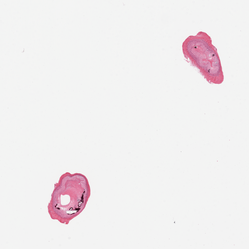

In [14]:
from wsidata import open_wsi

slide = "data/GTEX-1117F-0526.svs"

# Now we'll open the slide using the open_wsi function from wsidata
# This creates a WSIData object that contains both the image and associated metadata
wsi = open_wsi(slide)

# Let's examine what's in our WSI object
wsi

## 1.2 可视化

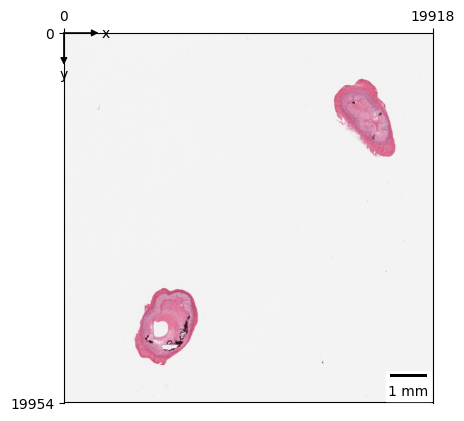

In [15]:
import lazyslide as zs

zs.pl.tissue(wsi)

## 1.3 探索金字塔结构

您会注意到这张幻灯片的金字塔中有 3 个级别，当向上移动金字塔时（随着级别数字的增加），会看到：

1. 图像尺寸（高度和宽度）逐渐变小
2. 下采样因子逐渐变大

In [ ]:
wsi.fetch.pyramids()

,height,width,downsample
level,,,
0,19958,19919,1.000000
1,4989,4979,4.000502
2,2494,2489,8.002609


## 1.4 了解 WSI 属性

现在让我们探讨一下整个幻灯片图像的重要属性。这些属性提供了有关图像尺寸、分辨率和其他对分析至关重要的特征的基本信息。

1. `shape`：全分辨率图像的尺寸（以像素为单位），以 `[width， height]` 形式提供。

2. `n_level`：图像金字塔中可用的分辨率级别数，包括完整分辨率。

3. `level_shape`：金字塔中每个级别的尺寸列表，从全分辨率到最低分辨率。

4. `level_downsample`：与全分辨率相比，每个级别的缩减采样因子，指示每个级别缩小了多少。

5. `mpp`（微米每像素）：一个像素的物理尺寸，以微米为单位，表示扫描分辨率。

6. 放大倍率 ：扫描过程中使用的光学放大倍数，有助于了解捕获图像的比例。

7. `bounds`：定义幻灯片上图像区域的边界框的坐标，以 `[x， y， width， height]` 的形式提供。

In [ ]:
wsi.properties

Field,Value
shape,"[19958, 19919]"
n_level,3
level_shape,"[[19958, 19919], [4989, 4979], [2494, 2489]]"
level_downsample,"[1.0, 4.000501706284455, 8.002609074152414]"
mpp,0.4942
magnification,20.0
bounds,"[0, 0, 19919, 19958]"


## 1.5 保存

In [6]:
wsi.write()

INFO     The Zarr backing store has been changed from None the new file path: data/GTEX-1117F-0526.zarr            


---

# 2. 预处理 

1. 加载和检查 WSI 数据
2. 从背景分割组织区域
3. 从大型 WSI 创建小的 patch
4. 从小的 patch 提取特征

## 2.1 组织分割

In [16]:
zs.pp.find_tissues(wsi)

绿线显示检测到的组织区域的边界，蓝色区域表示组织内将从分析中排除的孔或空白。

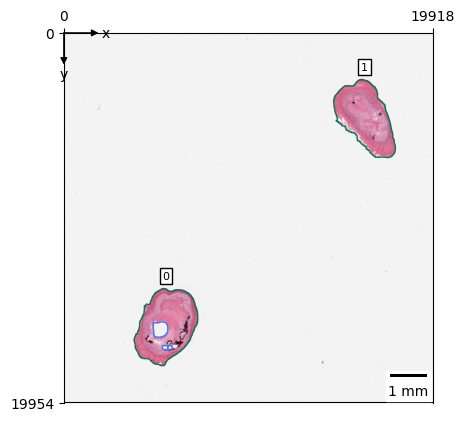

In [17]:
zs.pl.tissue(wsi)

组织分割算法的默认参数通常适用于大多数载玻片，但 LazySlide 提供了许多选项来根据需要微调分割。

## 2.2 检查分割结果

再次检查 WSIData 对象，会注意到一些新内容：名为 tissues 的 GeoDataFrame 已添加到 SpatialData 对象的 Shapes 插槽中。这是 LazySlide 存储有关我们识别的每个组织区域的几何信息的地方。

WSI: data/GTEX-1117F-0526.svs
Reader: openslide
Dimensions: 19958×19919 (h×w), 3 Pyramids
Pixel physical size: 0.4942 MPP
SpatialData object
├── Images
│     └── 'wsi_thumbnail': DataArray[cyx] (3, 1996, 1992)
└── Shapes
      └── 'tissues': GeoDataFrame shape: (2, 2) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images), tissues (Shapes)
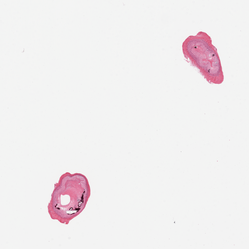

In [18]:
wsi

此表中的每一行代表一个不同的组织片段，并且每个组织都分配了一个唯一的 tissue_id。此标识符非常有用，因为它允许我们：

1. 在我们的分析中参考特定的组织片段
2. 跟踪不同加工步骤的组织碎片
3. 将作应用于单个组织而不是整个载玻片

In [ ]:
wsi["tissues"]

,tissue_id,geometry
0,0,"POLYGON ((5345.743 13804.501, 5337.74 13812.50..."
1,1,"POLYGON ((16029.226 2520.822, 16021.223 2528.8..."


## 2.3 专注于单个组织碎片

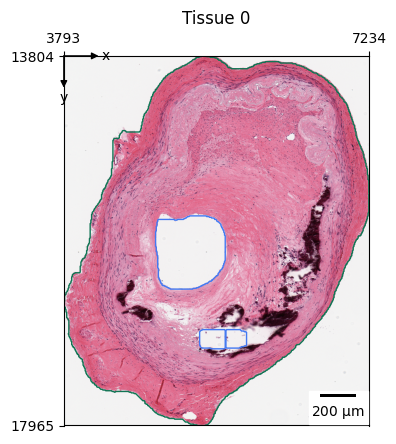

In [20]:
zs.pl.tissue(wsi, tissue_id=0)

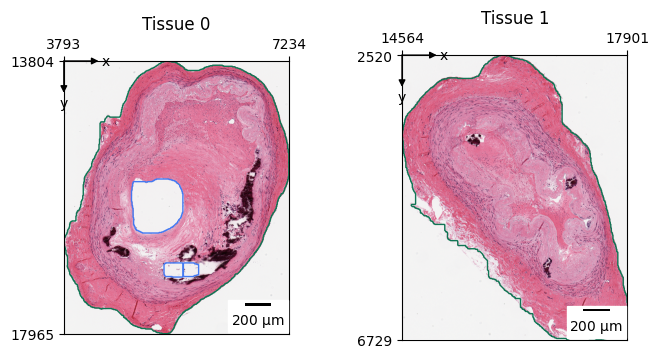

In [21]:
zs.pl.tissue(wsi, tissue_id="all")

In [22]:
wsi.write()

INFO     The Zarr backing store has been changed from None the new file path: data/GTEX-1117F-0526.zarr            


In [ ]:
# 加载以前的工作
wsi = open_wsi(slide)

version mismatch: detected: RasterFormatV02, requested: FormatV04
/home/zql/code/lazy_slide/.venv/lib/python3.12/site-packages/zarr/creation.py:610: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)


---

# 3. 基于深度学习的组织分割

In [25]:
zs.seg.tissue(wsi, key_added="dl-tissues")

'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /RendeiroLab/LazySlide-models-gpl/resolve/main/PathProfiler/pathprofiler_tissue_seg_jit.pt (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fa3b878f080>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: 6915d1ce-3baa-43ff-a36e-0ff381c8d320)')' thrown while requesting HEAD https://huggingface.co/RendeiroLab/LazySlide-models-gpl/resolve/main/PathProfiler/pathprofiler_tissue_seg_jit.pt
Retrying in 1s [Retry 1/5].
'(MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /RendeiroLab/LazySlide-models-gpl/resolve/main/PathProfiler/pathprofiler_tissue_seg_jit.pt (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fa3b878e7e0>: Failed to establish a new connection: [Errno 101] Network is unreachable'))"), '(Request ID: 308c532c-e78d-417b-9710-4f784

LocalEntryNotFoundError: An error happened while trying to locate the file on the Hub and we cannot find the requested files in the local cache. Please check your connection and try again or make sure your Internet connection is on.